Para este análisis se usó un conjunto de datos en el que se detallan los obsequios a funcionarios públicos registrados en el ámbito de la Oficina Anticorrupción.
Fuente: https://datos.gob.ar/dataset/justicia-registro-obsequios-funcionarios-publicos

In [127]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import os
import numpy as np
from os import path
from PIL import Image
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from collections import Counter

In [128]:
data = pd.read_csv("./data/registro-obsequios-funcionarios-publicos-20201009.csv")
print('Cantidad de registros cargados: {}'.format(len(data)))
#print(data.head())

Cantidad de registros cargados: 3928


In [129]:
# clean and unify features
data["funcionario_nombre"] = data["funcionario_nombre_completo"].apply(str.title) + " " + data["funcionario_apellido_completo"].apply(str.title)
data["obsequio_descripcion"] = data["obsequio_descripcion"].str.lower()

In [130]:
data[["obsequio_tipo"]].value_counts()

obsequio_tipo                    
Otros                                910
Libros                               907
Objetos en general                   734
Alimentos                            713
Artesanías (productos regionales)    335
Indumentaria                         197
Obras de arte                         70
Joyería y relojería                   39
Electrónicos                          19
Mobiliario                             4
dtype: int64

In [131]:
def make_wordcloud(data, filename):
    wc = WordCloud(background_color="black", width=1000, height=500).generate_from_frequencies(data)

    plt.figure(figsize=(15,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    wc.to_file(path.join(d, filename+".png"))

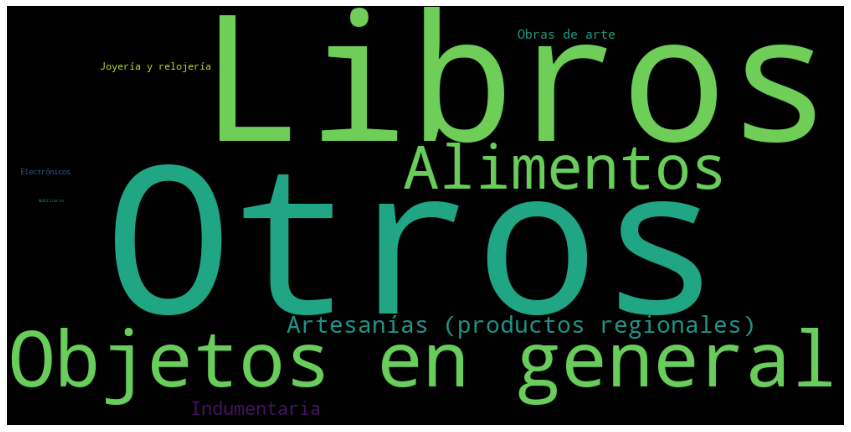

In [132]:
#generate wordCloud from types of gifts
word_could_dict = Counter(data.obsequio_tipo)
make_wordcloud(word_could_dict, "wordCloud_gifts_by_type")

In [133]:
#data[data["obsequio_tipo"]=="Otros"].obsequio_descripcion.head(10)
data[["funcionario_reparticion"]].value_counts()

funcionario_reparticion                             
Presidencia de la Nación                                1874
Ministerio de Relaciones Exteriores y Culto              207
Ministerio de Justicia y Derechos Humanos                127
Jefatura de Gabinete de Ministros                         73
Oficina Anticorrupción                                    70
                                                        ... 
MINISTERIO DE RELACIONES EXTERIORES Y CULTO                1
SUBSECRETARÍA DE AHORRO Y EFICIENCIA ENERGÉTICA            1
SUBSECRETARIA DE DESARROLLO INSTITUCIONAL PRODUCTIVO       1
MPYT                                                       1
Ministerio de Cultura                                      1
Length: 258, dtype: int64

In [134]:
gifts_by_value = data[["obsequio_valor_estimado","obsequio_tipo"]].groupby("obsequio_valor_estimado").count().sort_values("obsequio_tipo", ascending=False)
print("Valor aproximado de 4 módulos: $4.000")
print(gifts_by_value)

Valor aproximado de 4 módulos: $4.000
                                                    obsequio_tipo
obsequio_valor_estimado                                          
Inferior a 4 módulos.                                        3697
Superior a 4 módulos o imposibilidad de determi...            164
Inferior a 4 módulos pero con valor institucion...             67


In [135]:
gifts_received_by_role = data[["funcionario_nombre","obsequio_tipo"]].value_counts()
print(gifts_received_by_role.head(20))

funcionario_nombre                            obsequio_tipo                    
Mauricio Macri                                Libros                               500
                                              Otros                                402
                                              Objetos en general                   358
                                              Alimentos                            184
                                              Indumentaria                         125
Alberto Angel Fernandez                       Otros                                 95
                                              Libros                                67
Germán C. Garavano                            Libros                                53
Rogelio Frigerio                              Objetos en general                    45
Marcos Peña                                   Alimentos                             36
Alberto Jorge Triaca                          Alim

Lxs 10 funcionarixs que más regalos recibieron


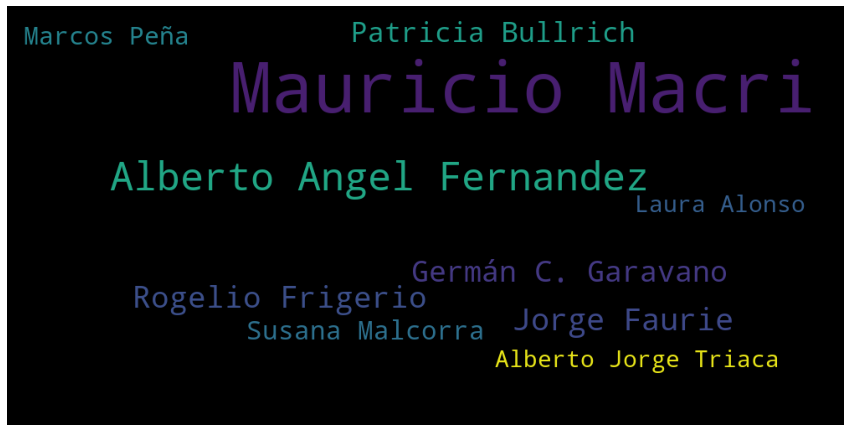

In [136]:
print("Lxs 10 funcionarixs que más regalos recibieron")
gift_by_func_counter = Counter(data.funcionario_nombre)
make_wordcloud(dict(gift_by_func_counter.most_common(10)), "roles_more_received_gifts_wordcloud")

In [137]:
gifts_by_date = data[["obsequio_fecha_registro"]].value_counts()
print("Días con más regalos:")
print(gifts_by_date.head(5))
# print("Día con más regalos: {} {}".format(gifts_by_date.idxmax()[0], gifts_by_date.head(1).values))
print(data.loc[(data["obsequio_fecha_registro"]=="2018-11-16") & (data["obsequio_tipo"]=="Otros"), ["obsequio_descripcion", "obsequio_valor_estimado"]].head(10))

#TODO tiene algo que ver la fecha con la cantidad de regalos??

Días con más regalos:
obsequio_fecha_registro
2018-11-16                 69
2017-08-24                 64
2019-01-17                 52
2018-09-27                 47
2019-11-27                 45
dtype: int64
                                   obsequio_descripcion  \
2199            un (1) escultura de un pajaro de madera   
2205                 una (1) lapicera de madera grabada   
2207        una (1) maqueta de una bomba oleohidráuilca   
2209                                        un (1) mate   
2213                 una (1) pintura en oleo de bebidas   
2216                              un (1) móbil colgante   
2217      una (1) pintura "la bandera argentina de hoy"   
2218  una (1) bandeja de plata -un (1) libro "200 - ...   
2219                          un (1) cuadro de una coya   
2227       un (1) cuadro en oleo: "esfuerzo al trabajo"   

     obsequio_valor_estimado  
2199   Inferior a 4 módulos.  
2205   Inferior a 4 módulos.  
2207   Inferior a 4 módulos.  
2209   Inferior a

Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)
https://www.argentina.gob.ar/justicia/igj/calculador-modulos
                                   obsequio_descripcion
obsequio_tipo                                          
Objetos en general                                   54
Otros                                                48
Obras de arte                                        22
Joyería y relojería                                  15
Artesanías (productos regionales)                    10
Alimentos                                             6
Libros                                                4
Indumentaria                                          3
Electrónicos                                          1
Mobiliario                                            1


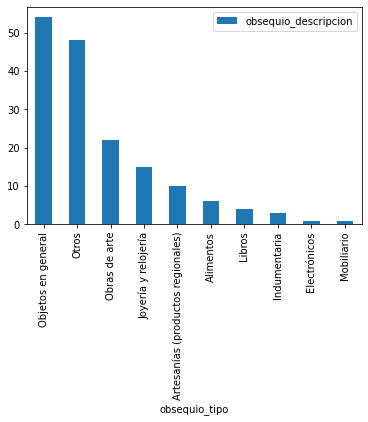

In [138]:
expensive_gifts = data[data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."]

print("Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)")
print("https://www.argentina.gob.ar/justicia/igj/calculador-modulos")
expensive_gifts_by_type = expensive_gifts[["obsequio_tipo", "obsequio_descripcion"]].groupby("obsequio_tipo").count().sort_values("obsequio_descripcion", ascending=False)

print(expensive_gifts_by_type)
expensive_gifts_by_type.plot(kind = 'bar')
plt.show()

In [139]:
print("Obsequios con un valor mayor a 4 módulos ($4.000)")
expensive_gifts["obsequio_descripcion"]

Obsequios con un valor mayor a 4 módulos ($4.000)


28      bolígrafo - montblanc - pix rollerball blue - ...
65                                              alfombras
104                  alfombra fbmi - modelo sultan mamluk
107      pañuelo hermes 90cm mythiques phoenix coloriages
142     "una (1) tetera de porcelana pintada-cuatro (4...
                              ...                        
3683                                        4 cajas de té
3702                                     bandeja de plata
3703                                        4 cajas de té
3704    caja de lata que contiene: una mascarilla de s...
3709    un mate de calabaza con detalle de alpaca y un...
Name: obsequio_descripcion, Length: 164, dtype: object

In [140]:
# Create a function to clean gift descriptions
def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace(" -- ",'').replace("-",',').replace(" , ",', ')
 text = text.replace("\"",'')
 text = re.sub(r'\(([0-9]+)\)', '', text)
 text = re.sub(' +', ' ', text)
 text = text.strip()
 return text

# Clean gift descriptions
expensive_gifts["clean_obsequio_descripcion"] = expensive_gifts.obsequio_descripcion.apply(cleanTxt)

#print(expensive_gifts.obsequio_descripcion.unique())
print(expensive_gifts.clean_obsequio_descripcion.unique())

['bolígrafo, montblanc, pix rollerball blue, serie 114809 origen: alemania'
 'alfombras' 'alfombra fbmi, modelo sultan mamluk'
 'pañuelo hermes 90cm mythiques phoenix coloriages'
 'una tetera de porcelana pintada,cuatro tazas sin asa de porcelana pintada,una caramelera de porcelana'
 'plato de porcelana, elaborado con la técnica de porcelana tierna, material pasta tierna.'
 'cafetera clasica de la hospitaridad arabe presentada en base caoba'
 'cuadro de estilo abstracto'
 'un juego de té de porcelana pintada a mano compuesto por una tetera, un plato y cinco tacitas'
 'un cuadro de singapur en acuarela'
 'un centro de mesa cuadrado de vidrio con flores'
 'una fuente de metal plateado con la casa blanca grabada'
 'un cuadro de la universidad de pensilvania'
 'un cuadro de vidrio con la imagen de un caballo'
 'una billetera color bordeaux salvatore ferragamo'
 'un marco de cristal con el escudo de la república italiana'
 'una fotografía del árbol jacaranda del autor matías costa'
 'una li

In [141]:
#tokenize gifts descriptions and remove spanish stopwords
nlp = Spanish(path=None)
#TODO consumir api de ML para obtener precio random de regalos?

for i in range(len(expensive_gifts)):
  gift = expensive_gifts[["clean_obsequio_descripcion"]].iloc[i][0]
  doc = nlp(gift)
  #tokens = [token.text for token in doc if not token.is_stop]
  tokens = [token for token in doc]
  print(tokens)

[bolígrafo, ,, montblanc, ,, pix, rollerball, blue, ,, serie, 114809, origen, :, alemania]
[alfombras]
[alfombra, fbmi, ,, modelo, sultan, mamluk]
[pañuelo, hermes, 90, cm, mythiques, phoenix, coloriages]
[una, tetera, de, porcelana, pintada, ,, cuatro, tazas, sin, asa, de, porcelana, pintada, ,, una, caramelera, de, porcelana]
[plato, de, porcelana, ,, elaborado, con, la, técnica, de, porcelana, tierna, ,, material, pasta, tierna, .]
[cafetera, clasica, de, la, hospitaridad, arabe, presentada, en, base, caoba]
[cuadro, de, estilo, abstracto]
[un, juego, de, té, de, porcelana, pintada, a, mano, compuesto, por, una, tetera, ,, un, plato, y, cinco, tacitas]
[un, cuadro, de, singapur, en, acuarela]
[un, centro, de, mesa, cuadrado, de, vidrio, con, flores]
[una, fuente, de, metal, plateado, con, la, casa, blanca, grabada]
[un, cuadro, de, la, universidad, de, pensilvania]
[un, cuadro, de, vidrio, con, la, imagen, de, un, caballo]
[una, billetera, color, bordeaux, salvatore, ferragamo]
[un,

In [142]:
stop_words = [token.text for token in doc if token.is_stop]
STOP_WORDS.update(stop_words)
print(STOP_WORDS.intersection(stop_words))

{'de', 'con', 'un', 'una'}


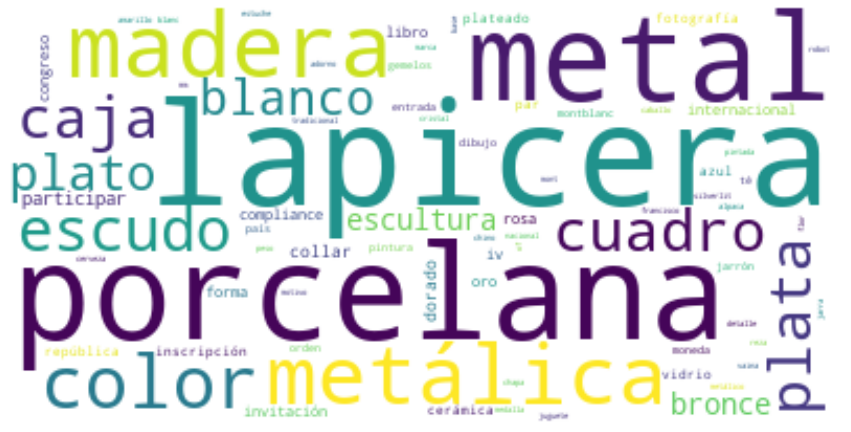

In [154]:
# word cloud visualization
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

allWords = ' '.join(expensive_gifts.clean_obsequio_descripcion)

wordCloud = WordCloud(background_color="white", random_state=21, stopwords=STOP_WORDS, collocations=False)

## uncomment to mask the generated wordcloud in a gift contour
#gift_mask = np.array(Image.open(path.join(d, "gift_mask.png")))
#wordCloud = WordCloud(background_color="white", random_state=21, stopwords=STOP_WORDS, mask=gift_mask, contour_width=2, contour_color="steelblue", collocations=False)

wordCloud.generate(allWords)

#show
plt.figure(figsize=(15,8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
## uncomment to mask the generated wordcloud in a gift contour
#plt.imshow(gift_mask, cmap=plt.cm.gray, interpolation="bilinear")
#plt.axis("off")
plt.show()

#store to file
wordCloud.to_file(path.join(d, "christmas_for_politicians.png"))

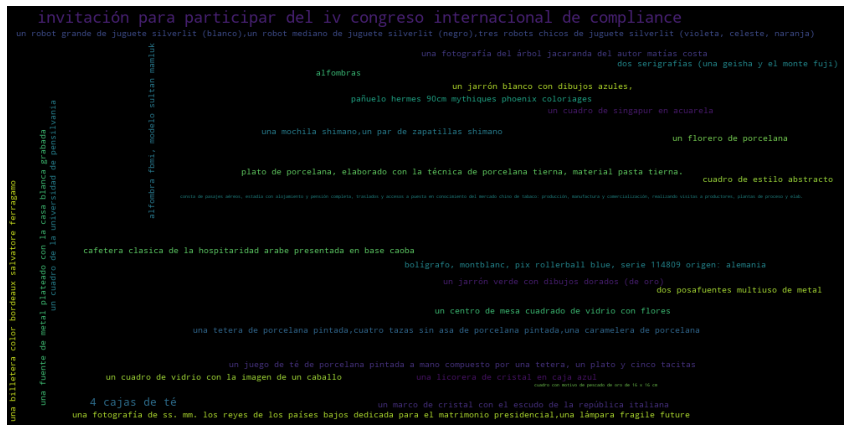

In [144]:
#generate wordCloud from full gift description
word_could_dict = Counter(expensive_gifts.clean_obsequio_descripcion)
make_wordcloud(dict(word_could_dict.most_common(30)), "gifts_wordCloud_from_frequencies")